# ISPR 2025 - Midterm 3 - Assignament 2 - Gianluca Panzani (550358)

In [249]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms

## Util methods

In [250]:
def get_img(img_dir: str, prefix: str, index: int, postfix: str, mask=False) -> Image:
    zeros = '00' if index < 10 else '0' if index < 100 else ''
    full_path = f'{img_dir}{prefix}{zeros}{index}{postfix}'
    if not mask:
        return Image.open(full_path).convert('RGB')
    return Image.open(full_path).convert('L')

def from_img_to_tensor(img: Image, resize_shape: tuple, mean=None, std=None) -> torch.Tensor:
    if mean is not None and std is not None:
        if not (len(mean) == 3 and len(std) == 3):
            raise ValueError('The image has 3 channles. The parameters "mean" and "std" have to be lists with length equal to 3.')
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor(), # Scaling
            transforms.Normalize(mean, std) # Normalization
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor() # Scaling
        ])
    return transform(img)
    
def from_mask_to_tensor(img: Image, resize_shape: tuple) -> torch.Tensor:
    img = img.resize(resize_shape, resample=Image.NEAREST)
    img_np = np.array(img)
    if img_np.max() > 1:
        img_np = (img_np > 127).astype(np.uint8)
    tensor = torch.from_numpy(img_np).float().unsqueeze(0)  # shape: [1, H, W]
    return tensor

def get_mean_and_std(images_dir: str, img_prefix: str, img_postfix: str, resize_shape: tuple):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    i = 0
    while True:
        i += 1
        try:
            image = get_img(img_dir=images_dir, prefix=img_prefix, index=i, postfix=img_postfix, mask=False)
        except:
            break
        img = from_img_to_tensor(img=image, resize_shape=resize_shape)
        mean += img.mean(dim=(1, 2)) # Mean computed on each channel (e.g. with RGB -> [meanR,meanG,meanB])
        std += img.std(dim=(1, 2)) # Std computed on each channel (e.g. with RGB -> [stdR,stdG,stdB])
    mean = (mean / (i-1)).tolist()
    std = (std / (i-1)).tolist()
    return mean, std

## Dataset class definition

In [ ]:
class HorseSegmentationDataset(Dataset):
    def __init__(self, images_dir, img_prefix, img_postfix, masks_dir, mask_prefix, mask_postfix, resize_shape=(128,128)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.resize_shape = resize_shape
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.img_postfix = img_postfix
        self.mask_postfix = mask_postfix
        self.length = len(os.listdir(images_dir))
        mean, std = get_mean_and_std(
            images_dir=self.images_dir,
            img_prefix=self.img_prefix,
            img_postfix=self.img_postfix,
            resize_shape=self.resize_shape
        )
        self.mean = mean
        self.std = std

    def __getitem__(self, index):
        img = get_img(self.images_dir, self.img_prefix, index+1, self.img_postfix, mask=False)
        mask = get_img(self.masks_dir, self.mask_prefix, index+1, self.mask_postfix, mask=True)
        img_tensor = from_img_to_tensor(img, self.resize_shape, self.mean, self.std)
        mask_tensor = from_mask_to_tensor(mask, self.resize_shape)
        return img_tensor, mask_tensor
    
    def __len__(self):
        return self.length



# Creation of the dataset object
dataset = HorseSegmentationDataset(
    images_dir='weizmann_horse_db/horse/',
    img_prefix='horse',
    img_postfix='.png',
    masks_dir='weizmann_horse_db/mask/',
    mask_prefix='horse',
    mask_postfix='.png',
    resize_shape=(128,128)
)

In [ ]:
class SegmentationCNN(nn.Module):
    def __init__(self,
                 encoder_channels: list[int],
                 decoder_channels: list[int],
                 encoder_kernel_sizes: list[int],
                 decoder_kernel_sizes: list[int],
                 encoder_strides: list[int],
                 decoder_strides: list[int],
                 output_padding: int):
        super(SegmentationCNN, self).__init__()
        # Encoder architecture
        layers = []
        for i in range(len(encoder_channels)-1):
            k = encoder_kernel_sizes[i]
            s = encoder_strides[i]
            layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=k, stride=s, padding=k//2))
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)
        # Decoder architecture
        layers = []
        for i in range(len(decoder_channels)-2):
            k = decoder_kernel_sizes[i]
            s = decoder_strides[i]
            layers.append(nn.ConvTranspose2d(decoder_channels[i], decoder_channels[i+1], kernel_size=k, stride=s, padding=k//2, output_padding=output_padding))
            layers.append(nn.ReLU())
        layers.append(nn.ConvTranspose2d(decoder_channels[-2], decoder_channels[-1], kernel_size=decoder_kernel_sizes[-1], stride=decoder_strides[-1]))
        layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return x

## Training method

In [253]:
def iou(preds: torch.Tensor, masks: torch.Tensor) -> float:
    preds = (preds > 0.5).float()
    masks = (masks > 0.5).float()
    # Compute intersection and union
    intersection = (preds * masks).sum()
    union = ((preds + masks) > 0).float().sum()
    # Case of empty union (the predictions and the masks are empty, so equal)
    if union == 0:
        return 1.0
    iou_score = intersection / union
    return iou_score.item()



def train(model: nn.Module, tr_dataloader: DataLoader, vl_dataloader: DataLoader, optimizer, criterion, device, epochs, threshold, verbose=1):
    model.to(device)
    model.train()

    # Initializations
    patience = 0
    prev_iou_avg_score = 1
    tr_losses = []
    vl_losses = []
    iou_scores = []

    # Iterate on the epochs
    for epoch in range(epochs):
        total_loss = 0.0

        # Iterate on the batches (of the training set)
        for imgs, masks in tr_dataloader:
            imgs = imgs.to(device)          # Move images' tensors on GPU or CPU
            masks = masks.to(device)        # Move masks' tensors on GPU or CPU

            preds = model(imgs)             # Compute the predictions
            loss = criterion(preds, masks)  # Compute the loss
            optimizer.zero_grad()           # Reset the gradients
            loss.backward()                 # Perform backpropagation
            optimizer.step()                # Update model's parameters (based on gradients)

            total_loss += loss.item()       # Update total loss with the average loss on this batch

        # Compute the average loss on the epoch
        tr_avg_loss = total_loss / len(tr_dataloader)
        tr_losses.append(tr_avg_loss)

        # Start validation phase
        model.eval()

        # Disable the update of the gradients
        with torch.no_grad():
            total_loss = 0.0
            total_iou = 0.0

            # Iterations on the batches (of the validation set)
            for imgs, masks in vl_dataloader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                preds = model(imgs)
                loss = criterion(preds, masks)

                total_loss += loss.item()
                total_iou += iou(preds, masks)

        vl_avg_loss = total_loss / len(vl_dataloader)
        vl_losses.append(vl_avg_loss)
        iou_avg_score = total_iou / len(vl_dataloader)
        iou_scores.append(iou_avg_score)

        # Early stopping (based on IoU score)
        if abs(prev_iou_avg_score - iou_avg_score) < threshold:
            patience += 1
        else:
            patience = 0
        if patience > 5:
            break
        prev_iou_avg_score = iou_avg_score

        # Print of the epoch result
        if verbose > 1:
            print(f'Epoch {epoch+1}/{epochs}: TR_loss={tr_avg_loss:.4f} - VL_loss={vl_avg_loss:.4f} - IoU={iou_avg_score:.4f}')
        elif verbose > 0:
            print(f'[{epoch+1}/{epochs}]:{iou_avg_score} - ', end='')
    
    return tr_losses, vl_losses, iou_scores

## Grid search
The best hyperparameters are searched with the Grid search technique.

In [ ]:
def get_params_combinations(params: dict) -> list[dict]:
    '''
    Creates and saves into the class instance a list with all the possible combinations of parameters \
    in the dictionary "params".

    Parameters:
    - params: dictionary with the parameters as associations <key:values> (with: key=parameter_name,
    values=possible_values_list).

    Returns:
    A list of dictionaries such that each one represents a combination of parameters (1 combination = 1 dictionary).
    '''
    params_index_dict = {}
    params_combinations = []
    for key in params.keys():
        params_index_dict[key] = 0 # current_index for that key
    while sum([index+1 for _, index in params_index_dict.items()]) != sum(len(val_list) for _, val_list in params.items()):
        params_i = {}
        for key, i in params_index_dict.items():
            params_i[key] = params[key][i]
        params_combinations.append(params_i)
        for key in params_index_dict.keys():
            params_index_dict[key] += 1
            if params_index_dict[key] < len(params[key]):
                break
            params_index_dict[key] = 0
    params_i = {}
    for key, i in params_index_dict.items():
        params_i[key] = params[key][i]
    params_combinations.append(params_i)
    return params_combinations


# Space of the hyperparameters
params_space = {
    'batch_size': [16, 32, 64],
    'learning_rate': [0.0001, 0.001],
    'epochs': [75],
    'threshold': [0.0001],
    'architecture': [
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,3], 'encoder_strides': [2,2,2],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [3,3,3], 'decoder_strides': [2,2,2],
            'output_padding': 1
        },
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,5], 'encoder_strides': [2,2,1],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [5,3,3], 'decoder_strides': [1,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128], 'encoder_kernel_sizes': [3,3,3,3], 'encoder_strides': [2,2,2,1],
            'decoder_channels': [128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3], 'decoder_strides': [1,2,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128,256], 'encoder_kernel_sizes': [3,3,3,3,3], 'encoder_strides': [2,2,2,2,1],
            'decoder_channels': [256,128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3,3], 'decoder_strides': [1,2,2,2,2],
            'output_padding': 0
        }
    ]
}

## Model selection

Hyperparameters [1/12]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64, 128], 'encoder_kernel_sizes': [3, 3, 3, 3], 'encoder_strides': [2, 2, 2, 1], 'decoder_channels': [128, 64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3, 3], 'decoder_strides': [1, 2, 2, 2], 'output_padding': 0}}
Epoch 1/75: TR_loss=0.7196 - VL_loss=0.6997 - IoU=0.2125
Epoch 2/75: TR_loss=0.6643 - VL_loss=0.6161 - IoU=0.0145
Epoch 3/75: TR_loss=0.6188 - VL_loss=0.5919 - IoU=0.0004
Epoch 4/75: TR_loss=0.5968 - VL_loss=0.5741 - IoU=0.0016
Epoch 5/75: TR_loss=0.5780 - VL_loss=0.5549 - IoU=0.0039
Epoch 6/75: TR_loss=0.5571 - VL_loss=0.5281 - IoU=0.0167
Epoch 7/75: TR_loss=0.5259 - VL_loss=0.4935 - IoU=0.0830
Epoch 8/75: TR_loss=0.4983 - VL_loss=0.4700 - IoU=0.1790
Epoch 9/75: TR_loss=0.4833 - VL_loss=0.4509 - IoU=0.3225
Epoch 10/75: TR_loss=0.4682 - VL_loss=0.4498 - IoU=0.2757
Epoch 11/75: TR_loss=0.4583 - VL_loss=0.4259 - IoU=0.3699
Epoch 12/75

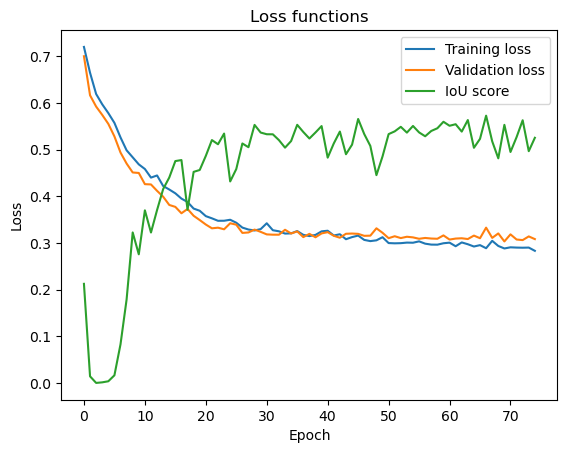

Hyperparameters [2/12]: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64, 128], 'encoder_kernel_sizes': [3, 3, 3, 3], 'encoder_strides': [2, 2, 2, 1], 'decoder_channels': [128, 64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3, 3], 'decoder_strides': [1, 2, 2, 2], 'output_padding': 0}}
Epoch 1/75: TR_loss=0.6366 - VL_loss=0.6309 - IoU=0.0000
Epoch 2/75: TR_loss=0.6299 - VL_loss=0.6199 - IoU=0.0000
Epoch 3/75: TR_loss=0.6169 - VL_loss=0.6006 - IoU=0.0000
Epoch 4/75: TR_loss=0.5961 - VL_loss=0.5834 - IoU=0.0000
Epoch 5/75: TR_loss=0.5797 - VL_loss=0.5717 - IoU=0.0000
Epoch 6/75: TR_loss=0.5703 - VL_loss=0.5597 - IoU=0.0000
Epoch 7/75: TR_loss=0.5652 - VL_loss=0.5461 - IoU=0.0010
Epoch 8/75: TR_loss=0.5388 - VL_loss=0.5282 - IoU=0.0046
Epoch 9/75: TR_loss=0.5263 - VL_loss=0.5089 - IoU=0.0320
Epoch 10/75: TR_loss=0.4986 - VL_loss=0.4925 - IoU=0.0928
Epoch 11/75: TR_loss=0.4879 - VL_loss=0.4847 - IoU=0.1784
Epoch 12/75

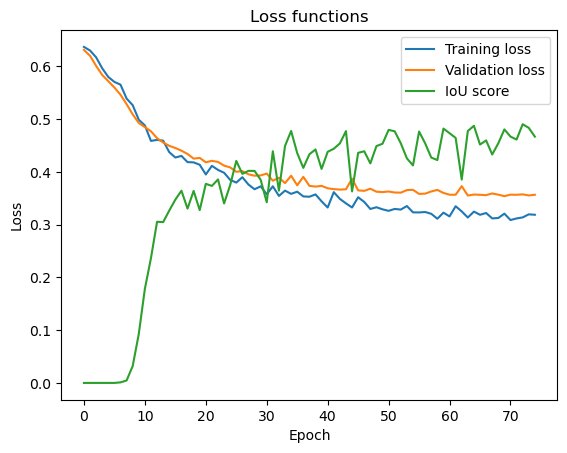

Hyperparameters [3/12]: {'batch_size': 64, 'learning_rate': 0.0001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64, 128], 'encoder_kernel_sizes': [3, 3, 3, 3], 'encoder_strides': [2, 2, 2, 1], 'decoder_channels': [128, 64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3, 3], 'decoder_strides': [1, 2, 2, 2], 'output_padding': 0}}
Epoch 1/75: TR_loss=0.7114 - VL_loss=0.7093 - IoU=0.2453
Epoch 2/75: TR_loss=0.7071 - VL_loss=0.7044 - IoU=0.2383
Epoch 3/75: TR_loss=0.7020 - VL_loss=0.6980 - IoU=0.1941
Epoch 4/75: TR_loss=0.6949 - VL_loss=0.6883 - IoU=0.1290
Epoch 5/75: TR_loss=0.6837 - VL_loss=0.6736 - IoU=0.0638
Epoch 6/75: TR_loss=0.6684 - VL_loss=0.6533 - IoU=0.0162
Epoch 7/75: TR_loss=0.6479 - VL_loss=0.6306 - IoU=0.0011
Epoch 8/75: TR_loss=0.6284 - VL_loss=0.6139 - IoU=0.0000
Epoch 9/75: TR_loss=0.6154 - VL_loss=0.6078 - IoU=0.0000
Epoch 10/75: TR_loss=0.6088 - VL_loss=0.6060 - IoU=0.0000
Epoch 11/75: TR_loss=0.6060 - VL_loss=0.6007 - IoU=0.0000
Epoch 12/75

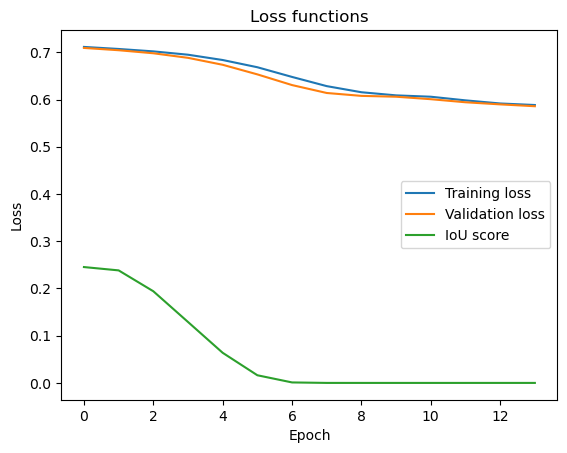

Hyperparameters [4/12]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64, 128], 'encoder_kernel_sizes': [3, 3, 3, 3], 'encoder_strides': [2, 2, 2, 1], 'decoder_channels': [128, 64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3, 3], 'decoder_strides': [1, 2, 2, 2], 'output_padding': 0}}
Epoch 1/75: TR_loss=0.5796 - VL_loss=0.4896 - IoU=0.0000
Epoch 2/75: TR_loss=0.4791 - VL_loss=0.4261 - IoU=0.3995
Epoch 3/75: TR_loss=0.4315 - VL_loss=0.3847 - IoU=0.5020
Epoch 4/75: TR_loss=0.3999 - VL_loss=0.3438 - IoU=0.5372
Epoch 5/75: TR_loss=0.4116 - VL_loss=0.3980 - IoU=0.4659
Epoch 6/75: TR_loss=0.3811 - VL_loss=0.3528 - IoU=0.5304
Epoch 7/75: TR_loss=0.3598 - VL_loss=0.3268 - IoU=0.5499
Epoch 8/75: TR_loss=0.3386 - VL_loss=0.3196 - IoU=0.5536
Epoch 9/75: TR_loss=0.3295 - VL_loss=0.3145 - IoU=0.5719
Epoch 10/75: TR_loss=0.3233 - VL_loss=0.3158 - IoU=0.5513
Epoch 11/75: TR_loss=0.3102 - VL_loss=0.3256 - IoU=0.5311
Epoch 12/75:

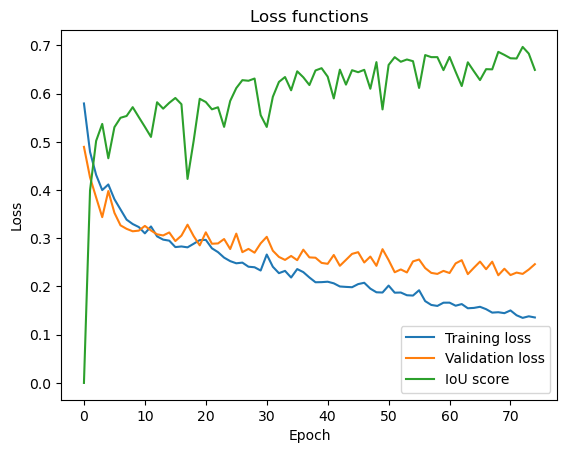

Hyperparameters [5/12]: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64, 128], 'encoder_kernel_sizes': [3, 3, 3, 3], 'encoder_strides': [2, 2, 2, 1], 'decoder_channels': [128, 64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3, 3], 'decoder_strides': [1, 2, 2, 2], 'output_padding': 0}}
Epoch 1/75: TR_loss=0.6940 - VL_loss=0.6108 - IoU=0.0085
Epoch 2/75: TR_loss=0.6028 - VL_loss=0.5753 - IoU=0.0001
Epoch 3/75: TR_loss=0.5413 - VL_loss=0.5285 - IoU=0.1196
Epoch 4/75: TR_loss=0.5134 - VL_loss=0.4874 - IoU=0.1784
Epoch 5/75: TR_loss=0.4592 - VL_loss=0.4723 - IoU=0.2990
Epoch 6/75: TR_loss=0.4405 - VL_loss=0.4509 - IoU=0.3467
Epoch 7/75: TR_loss=0.4248 - VL_loss=0.4346 - IoU=0.3067
Epoch 8/75: TR_loss=0.4003 - VL_loss=0.4389 - IoU=0.2747
Epoch 9/75: TR_loss=0.3858 - VL_loss=0.4261 - IoU=0.3670
Epoch 10/75: TR_loss=0.3728 - VL_loss=0.3832 - IoU=0.4043
Epoch 11/75: TR_loss=0.3355 - VL_loss=0.3779 - IoU=0.4518
Epoch 12/75:

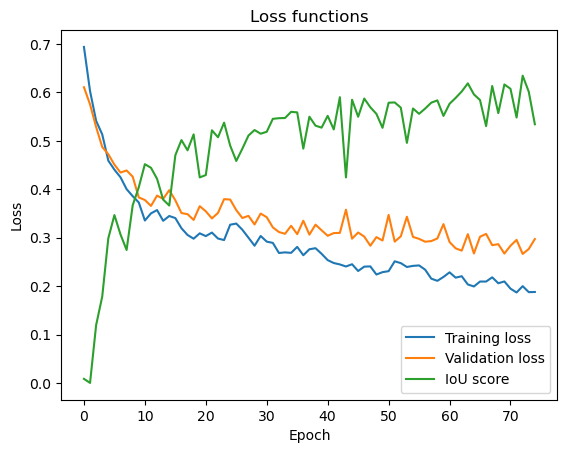

Hyperparameters [6/12]: {'batch_size': 64, 'learning_rate': 0.001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64, 128], 'encoder_kernel_sizes': [3, 3, 3, 3], 'encoder_strides': [2, 2, 2, 1], 'decoder_channels': [128, 64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3, 3], 'decoder_strides': [1, 2, 2, 2], 'output_padding': 0}}
Epoch 1/75: TR_loss=0.6595 - VL_loss=0.6005 - IoU=0.0000
Epoch 2/75: TR_loss=0.5956 - VL_loss=0.5813 - IoU=0.0000
Epoch 3/75: TR_loss=0.5652 - VL_loss=0.5471 - IoU=0.0000
Epoch 4/75: TR_loss=0.5240 - VL_loss=0.5147 - IoU=0.0000
Epoch 5/75: TR_loss=0.4924 - VL_loss=0.4970 - IoU=0.0000
Epoch 6/75: TR_loss=0.4825 - VL_loss=0.4837 - IoU=0.0003
Epoch 7/75: TR_loss=0.4717 - VL_loss=0.4710 - IoU=0.0011
Epoch 8/75: TR_loss=0.4401 - VL_loss=0.4521 - IoU=0.0399
Epoch 9/75: TR_loss=0.4301 - VL_loss=0.4361 - IoU=0.0895
Epoch 10/75: TR_loss=0.4112 - VL_loss=0.4392 - IoU=0.2813
Epoch 11/75: TR_loss=0.3948 - VL_loss=0.4224 - IoU=0.2686
Epoch 12/75:

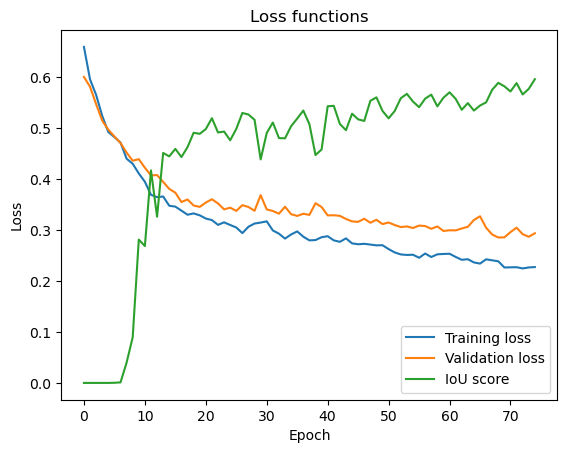

Hyperparameters [7/12]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/75: TR_loss=0.6478 - VL_loss=0.6394 - IoU=0.0000
Epoch 2/75: TR_loss=0.6347 - VL_loss=0.6241 - IoU=0.0000
Epoch 3/75: TR_loss=0.6174 - VL_loss=0.6036 - IoU=0.0000
Epoch 4/75: TR_loss=0.6005 - VL_loss=0.5805 - IoU=0.0000
Epoch 5/75: TR_loss=0.5837 - VL_loss=0.5616 - IoU=0.0000
Epoch 6/75: TR_loss=0.5685 - VL_loss=0.5490 - IoU=0.0000


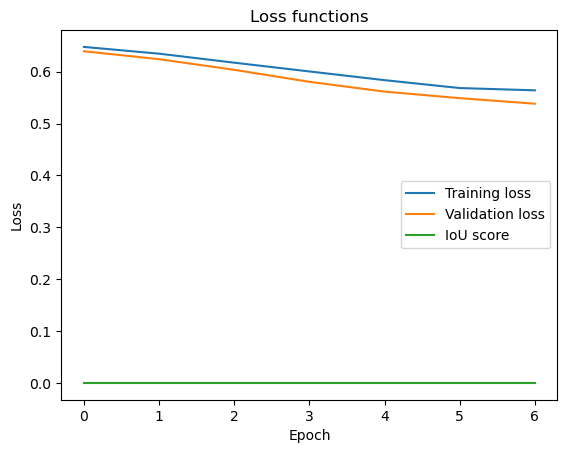

Hyperparameters [8/12]: {'batch_size': 32, 'learning_rate': 0.0001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/75: TR_loss=0.6306 - VL_loss=0.6269 - IoU=0.0000
Epoch 2/75: TR_loss=0.6276 - VL_loss=0.6222 - IoU=0.0000
Epoch 3/75: TR_loss=0.6222 - VL_loss=0.6171 - IoU=0.0000
Epoch 4/75: TR_loss=0.6177 - VL_loss=0.6108 - IoU=0.0000
Epoch 5/75: TR_loss=0.6110 - VL_loss=0.6029 - IoU=0.0000
Epoch 6/75: TR_loss=0.6048 - VL_loss=0.5928 - IoU=0.0000


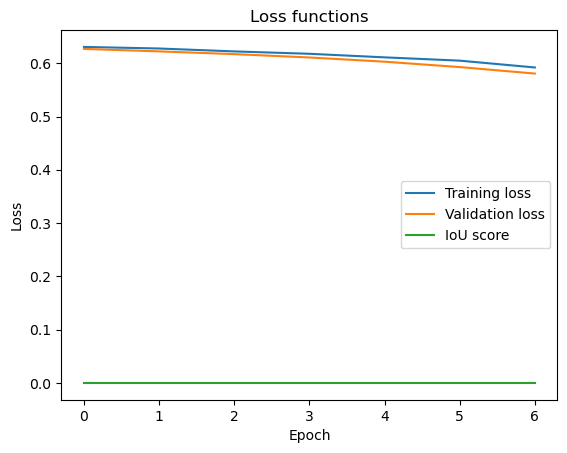

Hyperparameters [9/12]: {'batch_size': 64, 'learning_rate': 0.0001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/75: TR_loss=0.7524 - VL_loss=0.7493 - IoU=0.2466
Epoch 2/75: TR_loss=0.7442 - VL_loss=0.7409 - IoU=0.2467
Epoch 3/75: TR_loss=0.7360 - VL_loss=0.7323 - IoU=0.2426
Epoch 4/75: TR_loss=0.7281 - VL_loss=0.7236 - IoU=0.2308
Epoch 5/75: TR_loss=0.7195 - VL_loss=0.7150 - IoU=0.2139
Epoch 6/75: TR_loss=0.7110 - VL_loss=0.7061 - IoU=0.1949
Epoch 7/75: TR_loss=0.7028 - VL_loss=0.6969 - IoU=0.1730
Epoch 8/75: TR_loss=0.6938 - VL_loss=0.6873 - IoU=0.1495
Epoch 9/75: TR_loss=0.6852 - VL_loss=0.6773 - IoU=0.1256
Epoch 10/75: TR_loss=0.6744 - VL_loss=0.6672 - IoU=0.1020
Epoch 11/75: TR_loss=0.6659 - VL_loss=0.6570 - IoU=0.0800
Epoch 12/75: TR_loss=0.6556 - VL_

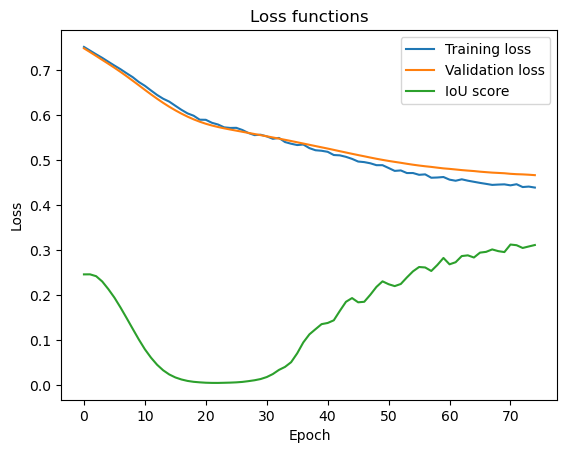

Hyperparameters [10/12]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/75: TR_loss=0.6016 - VL_loss=0.5302 - IoU=0.0194
Epoch 2/75: TR_loss=0.5323 - VL_loss=0.4799 - IoU=0.1437
Epoch 3/75: TR_loss=0.4763 - VL_loss=0.4539 - IoU=0.1817
Epoch 4/75: TR_loss=0.4516 - VL_loss=0.3977 - IoU=0.4562
Epoch 5/75: TR_loss=0.4353 - VL_loss=0.3906 - IoU=0.4463
Epoch 6/75: TR_loss=0.4180 - VL_loss=0.4351 - IoU=0.1839
Epoch 7/75: TR_loss=0.4140 - VL_loss=0.3755 - IoU=0.4982
Epoch 8/75: TR_loss=0.4059 - VL_loss=0.3842 - IoU=0.4686
Epoch 9/75: TR_loss=0.3955 - VL_loss=0.3757 - IoU=0.4699
Epoch 10/75: TR_loss=0.3901 - VL_loss=0.3806 - IoU=0.3990
Epoch 11/75: TR_loss=0.3879 - VL_loss=0.3688 - IoU=0.4707
Epoch 12/75: TR_loss=0.3859 - VL_

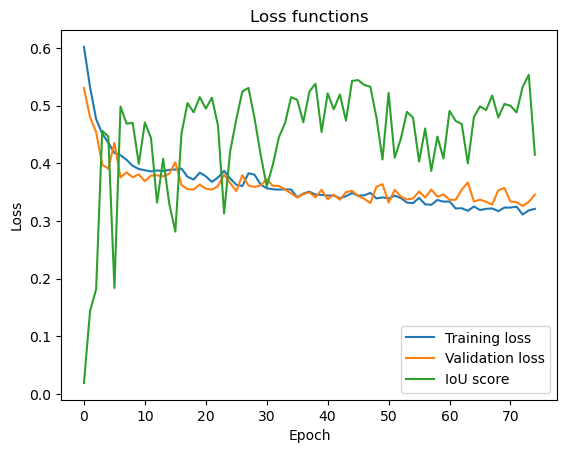

Hyperparameters [11/12]: {'batch_size': 32, 'learning_rate': 0.001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/75: TR_loss=0.6074 - VL_loss=0.5626 - IoU=0.0000
Epoch 2/75: TR_loss=0.5603 - VL_loss=0.5335 - IoU=0.0066
Epoch 3/75: TR_loss=0.5175 - VL_loss=0.5031 - IoU=0.1910
Epoch 4/75: TR_loss=0.4807 - VL_loss=0.4715 - IoU=0.2886
Epoch 5/75: TR_loss=0.4670 - VL_loss=0.4674 - IoU=0.2204
Epoch 6/75: TR_loss=0.4628 - VL_loss=0.4523 - IoU=0.2612
Epoch 7/75: TR_loss=0.4245 - VL_loss=0.4455 - IoU=0.4010
Epoch 8/75: TR_loss=0.4296 - VL_loss=0.4563 - IoU=0.2408
Epoch 9/75: TR_loss=0.4185 - VL_loss=0.4382 - IoU=0.3964
Epoch 10/75: TR_loss=0.4152 - VL_loss=0.4592 - IoU=0.2828
Epoch 11/75: TR_loss=0.4256 - VL_loss=0.4356 - IoU=0.3956
Epoch 12/75: TR_loss=0.4221 - VL_

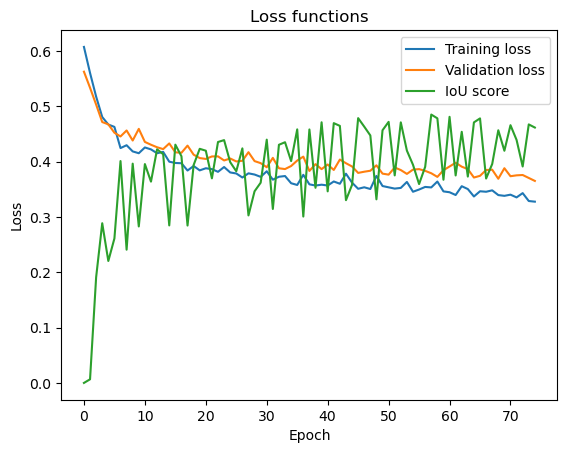

Hyperparameters [12/12]: {'batch_size': 64, 'learning_rate': 0.001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/75: TR_loss=0.6340 - VL_loss=0.6179 - IoU=0.0000
Epoch 2/75: TR_loss=0.6143 - VL_loss=0.5944 - IoU=0.0002
Epoch 3/75: TR_loss=0.5860 - VL_loss=0.5647 - IoU=0.0062
Epoch 4/75: TR_loss=0.5514 - VL_loss=0.5353 - IoU=0.0702
Epoch 5/75: TR_loss=0.5286 - VL_loss=0.5200 - IoU=0.1758
Epoch 6/75: TR_loss=0.5058 - VL_loss=0.4949 - IoU=0.2742
Epoch 7/75: TR_loss=0.4818 - VL_loss=0.4760 - IoU=0.2742
Epoch 8/75: TR_loss=0.4641 - VL_loss=0.4603 - IoU=0.3269
Epoch 9/75: TR_loss=0.4522 - VL_loss=0.4527 - IoU=0.3474
Epoch 10/75: TR_loss=0.4427 - VL_loss=0.4503 - IoU=0.3169
Epoch 11/75: TR_loss=0.4358 - VL_loss=0.4483 - IoU=0.3711
Epoch 12/75: TR_loss=0.4367 - VL_

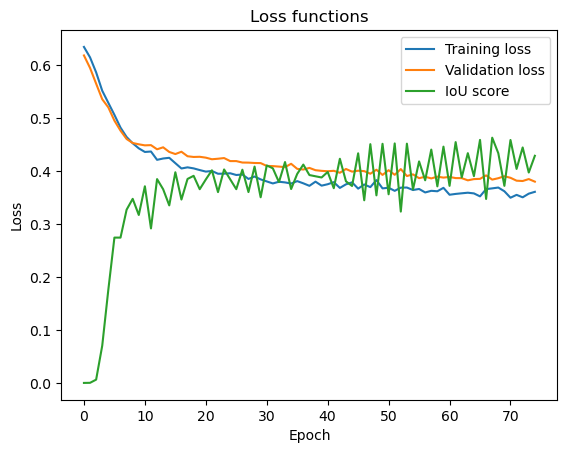

In [255]:
def show_plots(values_list: list[list], labels: list[str]):
    for i, values in enumerate(values_list):
        plt.plot(values, label=labels[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss functions')
    plt.show()


# Iterates on each parameters combination obtained from the parameters space
tr_dataset, vl_dataset, ts_dataset = random_split(dataset, [0.70,0.15,0.15])
params_list = get_params_combinations(params_space)
models = {}
for i, params in enumerate(params_list):
    print(f'Hyperparameters [{i+1}/{len(params_list)}]: {params}')

    # Datasets initializations
    tr_loader = DataLoader(tr_dataset, batch_size=params['batch_size'], shuffle=True)
    vl_loader = DataLoader(vl_dataset, batch_size=params['batch_size'], shuffle=False)

    # Create the model
    model = SegmentationCNN(**params['architecture'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = torch.nn.BCELoss()

    # Training phase
    tr_losses, vl_losses, iou_scores = train(
        model,
        tr_dataloader=tr_loader,
        vl_dataloader=vl_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        epochs=params['epochs'],
        threshold=params['threshold'],
        verbose=2
    )

    # Insert the model in the dictionary
    models[i] = {
        'model': model,
        'params': params,
        'vl_losses': vl_losses,
        'tr_losses': tr_losses
    }

    # Shows the Loss plots
    show_plots(
        values_list=[tr_losses,vl_losses,iou_scores],
        labels=['Training loss','Validation loss','IoU score']
    )

# Select the best model (with the lowest validation loss)
best_model_obj = min(models.items(), key=lambda x: x[1]['vl_losses'][-1])[1]


## Model evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0198..2.3291008].


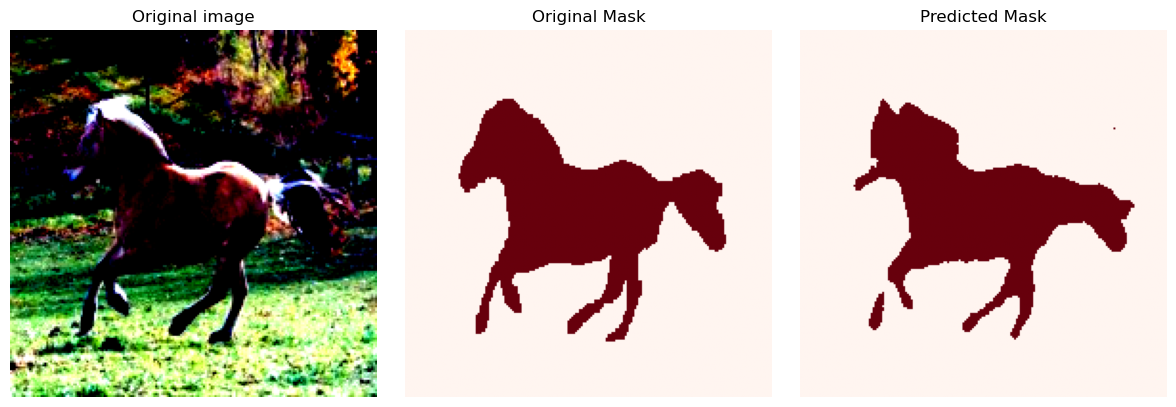

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9705514..2.5326912].


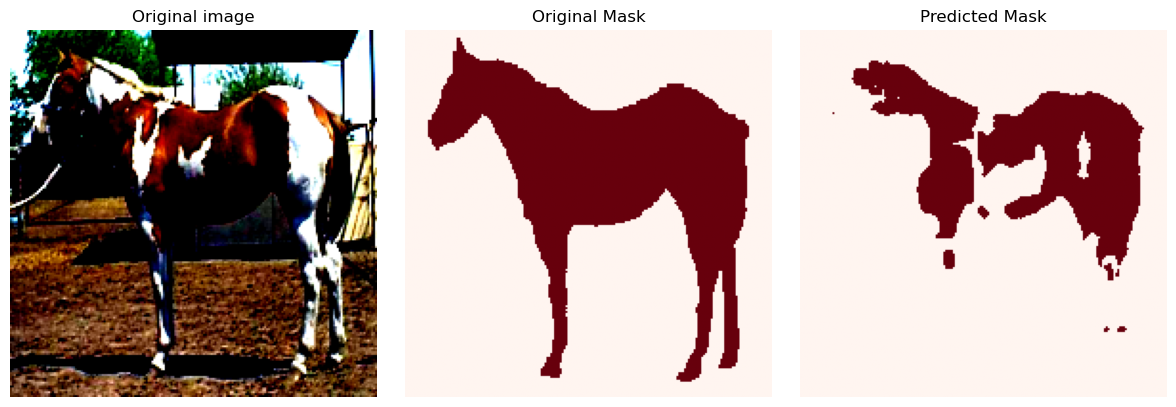

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1018813..2.5326912].


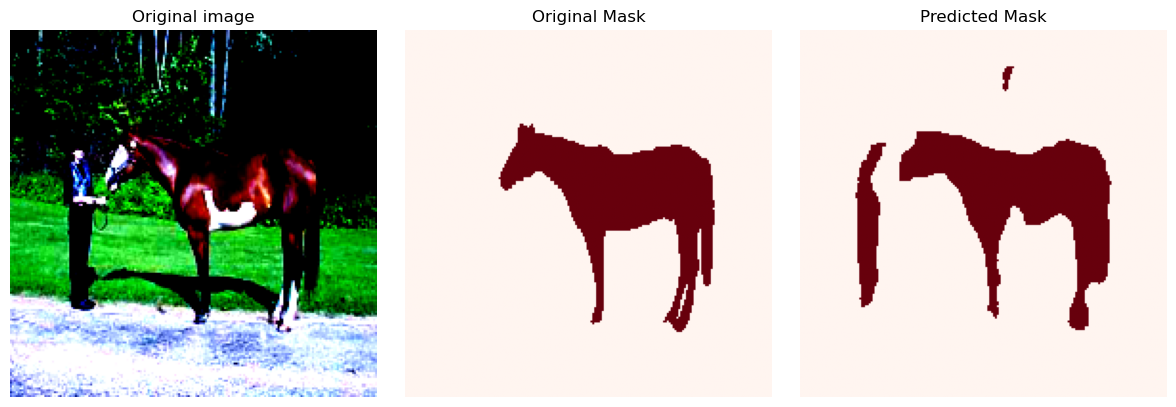

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0033839..2.5326912].


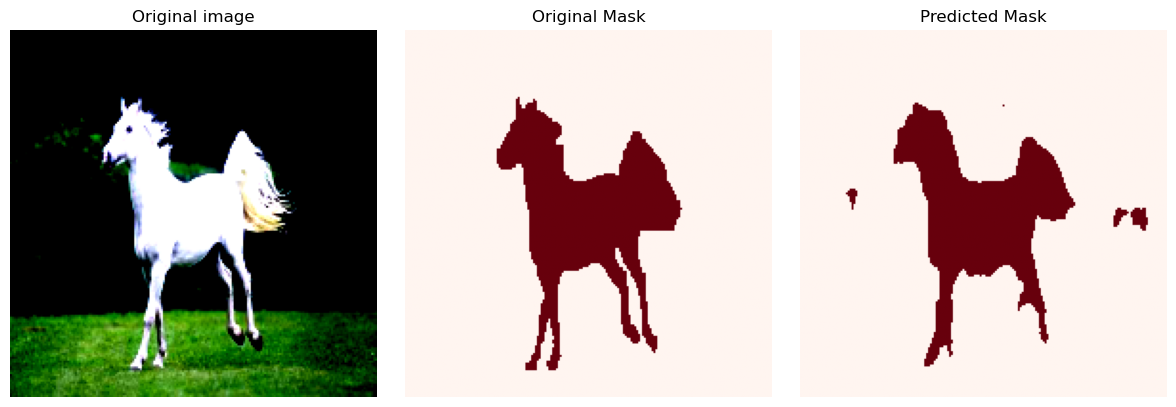

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1018813..2.5326912].


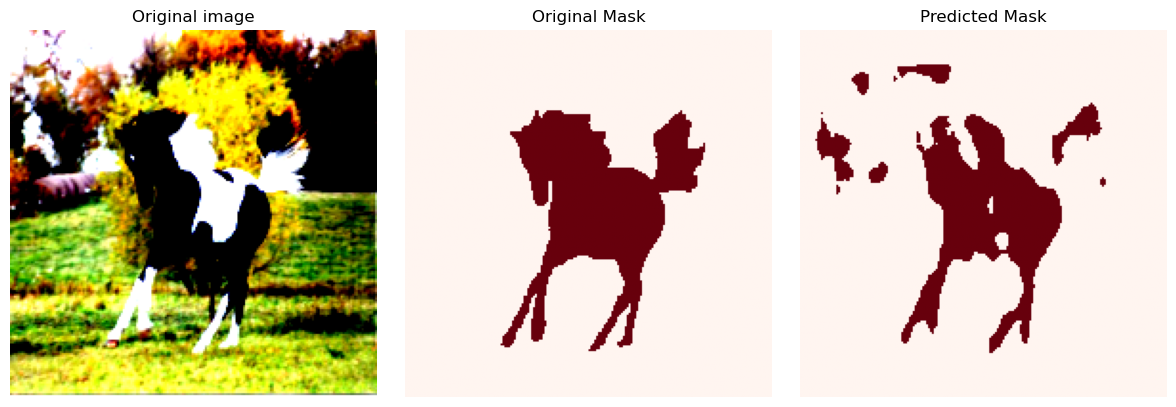

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6586429..2.4987595].


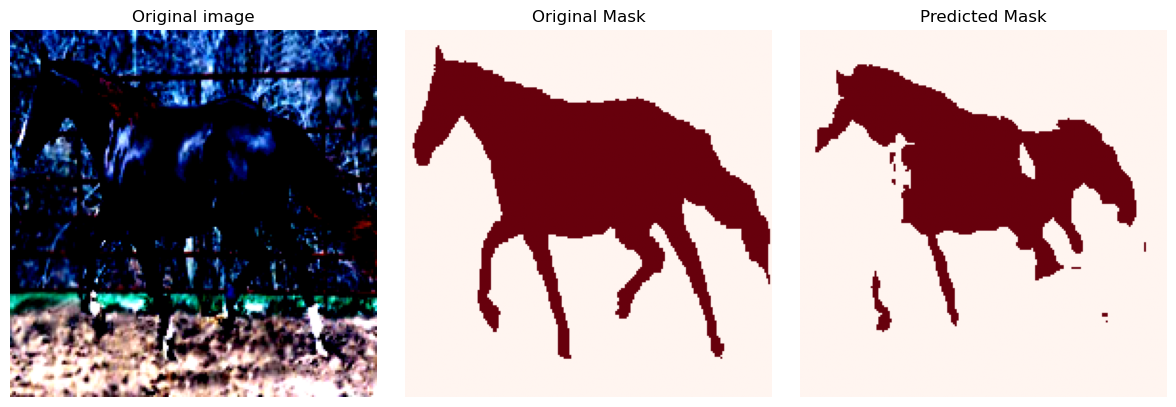

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0526326..1.8710227].


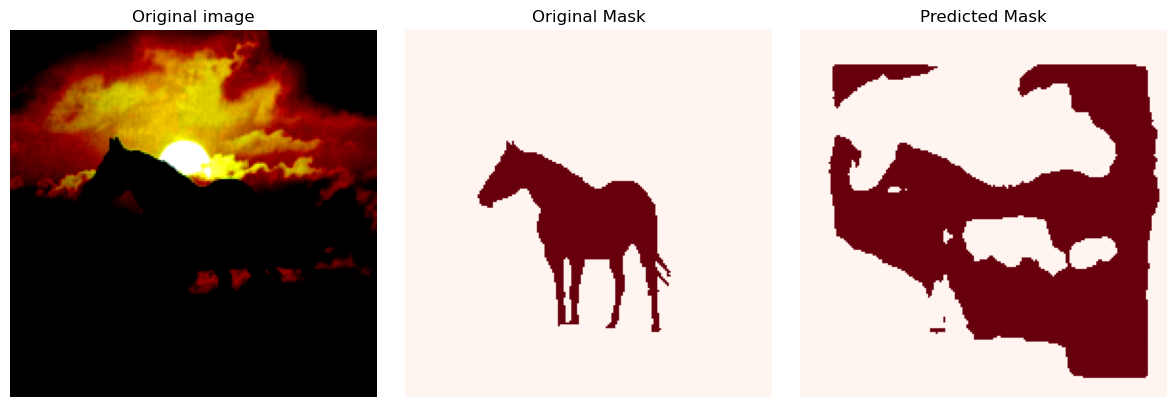

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9876434..2.5326912].


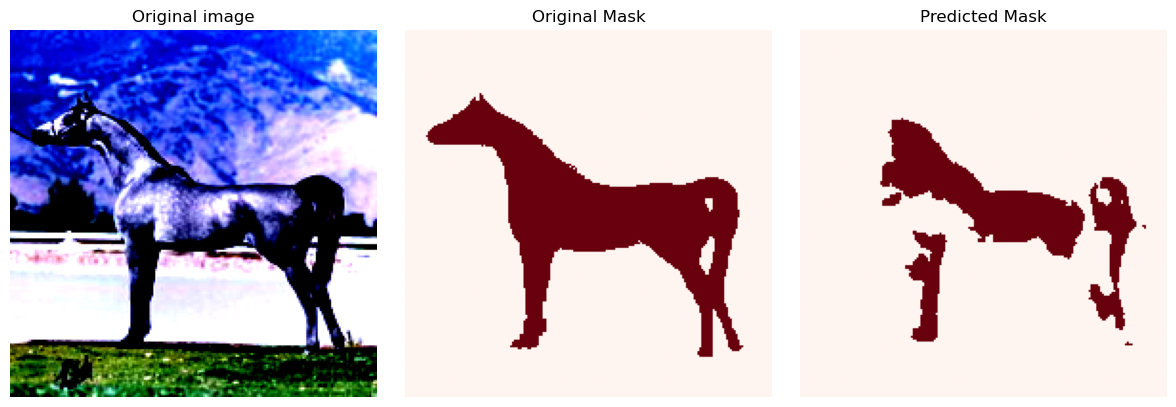

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1018813..2.5326912].


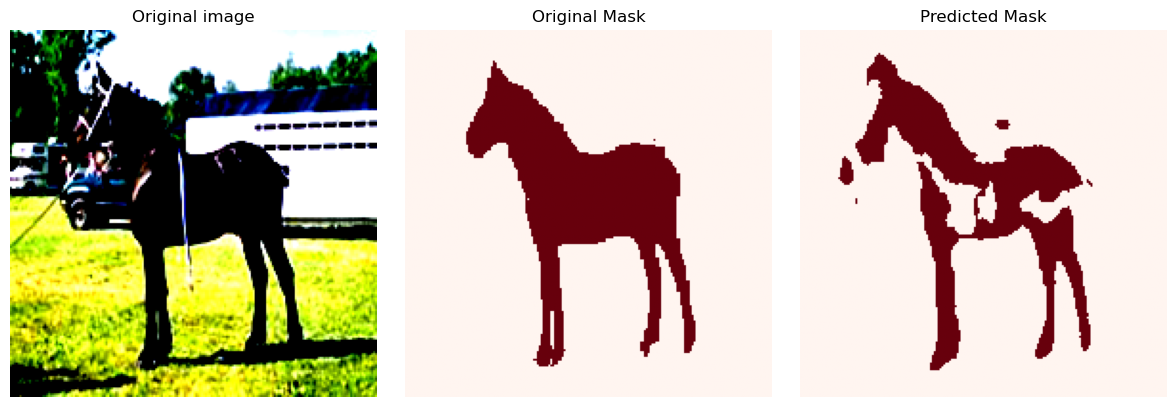

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0690486..1.8979219].


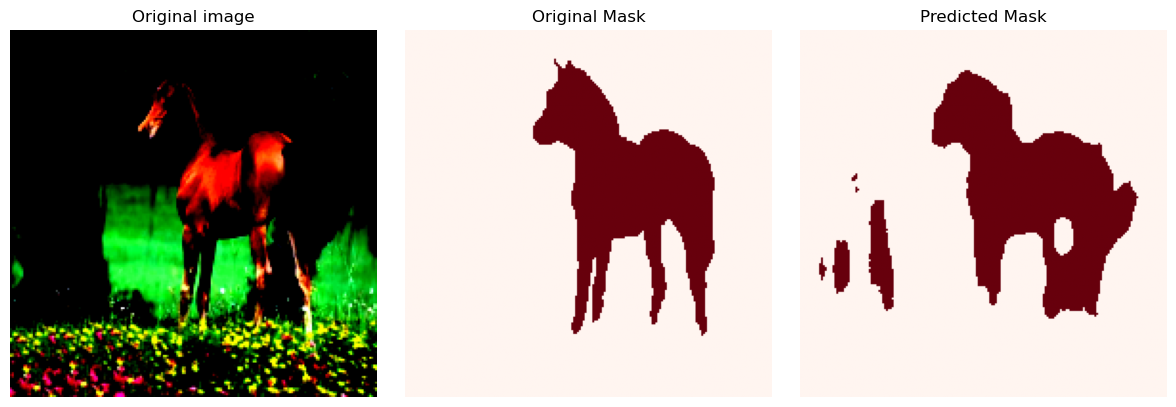

Best model parameters: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 75, 'threshold': 0.0001, 'architecture': {'encoder_channels': [3, 32, 64, 128], 'encoder_kernel_sizes': [3, 3, 3, 3], 'encoder_strides': [2, 2, 2, 1], 'decoder_channels': [128, 64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3, 3], 'decoder_strides': [1, 2, 2, 2], 'output_padding': 0}}
Test Loss: 0.24924851953983307
Test IoU score: 0.6718368381261826


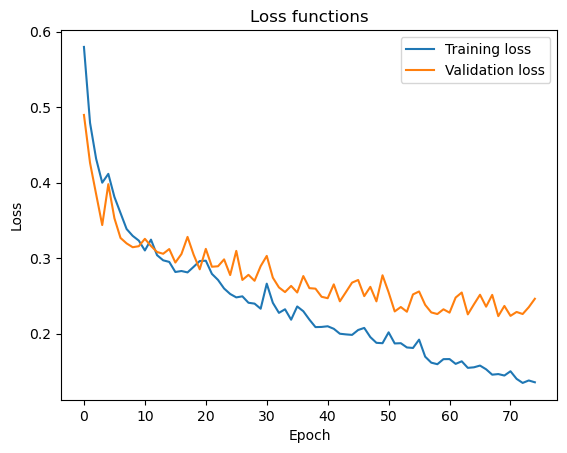

In [256]:
def show_prediction_plot(img, mask, pred):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title('Original image')
    axs[0].axis('off')
    axs[1].imshow(mask, cmap='Reds')
    axs[1].set_title('Original Mask')
    axs[1].axis('off')
    axs[2].imshow(pred, cmap='Reds')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()



def evaluate(model: nn.Module, ts_dataloader: DataLoader, criterion, device):
    model.eval()
    model.to(device)

    # Initializations
    total_loss = 0.0
    total_iou = 0.0
    n_imgs_to_show = 10
    shown = 0

    with torch.no_grad():
        for imgs, masks in ts_dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Compute the predictions and the loss
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item()

            # Binarization of the predictions
            preds = (preds > 0.5).float()

            # Case of plot of the images
            if shown < n_imgs_to_show:
                # Matplotlib can't handle GPU tensors (so we need to move them to CPU)
                imgs_cpu = imgs.cpu()
                masks_cpu = masks.cpu()
                preds_cpu = preds.cpu()
                # Plot the images
                for img, mask, pred in zip(imgs_cpu, masks_cpu, preds_cpu):
                    mask = (mask > 0.5).float()
                    pred = (pred > 0.5).float()
                    if shown == n_imgs_to_show:
                        break
                    show_prediction_plot(img.permute(1,2,0), mask[0], pred[0])
                    shown += 1

            # Compute the number of correct pixels predicted
            total_iou += iou(preds, masks)

    # Accuracy and average loss
    iou_avg_score = total_iou / len(ts_dataloader)
    avg_loss = total_loss / len(ts_dataloader)
    return iou_avg_score, avg_loss



# Create the test dataloader
ts_loader = DataLoader(ts_dataset, batch_size=best_model_obj['params']['batch_size'], shuffle=False)

# Evaluation phase
iou_score, avg_loss = evaluate(
    model=best_model_obj['model'],
    ts_dataloader=ts_loader,
    criterion=criterion,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Show the results
print(f'Best model parameters: {best_model_obj["params"]}')
print(f'Test Loss: {avg_loss}')
print(f'Test IoU score: {iou_score}')
show_plots(values_list=[best_model_obj['tr_losses'], best_model_obj['vl_losses']], labels=['Training loss','Validation loss'])